In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress tracking


class TrajectoryDataset(Dataset):
    def __init__(self, dataframe, window_length=100):
        # Perform the custom transformation
        sliced_df = self.custom_transformation(dataframe.to_numpy(), window_length=window_length)
        self.data = torch.tensor(sliced_df, dtype=torch.float32)

    def __len__(self):
        # Return the number of trajectories
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Get the trajectory at the given index
        return self.data[idx]

    def custom_transformation(self, dataframe_array, window_length):
        num_rows, num_cols = dataframe_array.shape
        window_length += 1  # get one more column as targets

        # Preallocate memory for the slices
        sliced_data = np.lib.stride_tricks.sliding_window_view(dataframe_array, window_shape=(window_length,), axis=1)
        
        # Reshape into a flat 2D array for DataFrame-like output
        sliced_data = sliced_data.reshape(-1, window_length)

        return sliced_data
    
# Implement your model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward pass through GRU
        out, _ = self.gru(x)  # out shape: [batch_size, sequence_length, hidden_size]
    
        # If sequence length is missing, unsqueeze to add it back
        if out.dim() == 2:
            out = out.unsqueeze(1)  # Ensures out has the correct dimension
    
        # Select the output from the last time step
        out = self.fc(out[:, -1, :])  # Shape [batch_size, output_size]
        return out


## Training loop

In [39]:
import os

# Get the relative path of a file in the current working directory
train_path = os.path.join('train.csv')
val_path = os.path.join('val.csv')
test_path = os.path.join('test.csv')

train_df = pd.read_csv(train_path, header = 0).drop('ids', axis=1)
val_df = pd.read_csv(val_path, header = 0).drop('ids', axis=1)
test_df = pd.read_csv(test_path, header = 0).drop('ids', axis=1)


In [40]:
# Check if MPS is available and set the device accordingly
device = torch.device('cpu')
if torch.cuda.is_available():
    print("Cuda is available!")
    device = torch.device("cuda")

window_length = 100  # Example window length
dataset = TrajectoryDataset(dataframe=train_df, window_length=window_length)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model hyperparameters
input_size = window_length  # Window length minus 1 (since the last column is the target)
hidden_size = 64
output_size = 1  # Single output for time series forecast (next value)
learning_rate = 0.001
num_epochs = 1
num_layers = 2

# Instantiate the model, loss function, and optimizer
model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with tqdm for progress tracking
for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
    model.train()
    running_loss = 0.0
    # Use tqdm to track batch progress within each epoch
    for batch_idx, data in tqdm(enumerate(dataloader), desc=f"Epoch {epoch + 1}", unit="batch", leave=False):
        # Separate inputs and targets
        inputs = data[:, :-1].to(device)  # All except last column
        targets = data[:, -1].to(device)  # Last column is the target (next value)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs.squeeze(), targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss per epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')

Cuda is available!


Epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]
Epoch 1: 0batch [00:00, ?batch/s]
Epoch 1: 1batch [00:00,  6.02batch/s]
Epoch 1: 82batch [00:00, 375.76batch/s]
Epoch 1: 164batch [00:00, 551.72batch/s]
Epoch 1: 247batch [00:00, 649.77batch/s]
Epoch 1: 329batch [00:00, 705.63batch/s]
Epoch 1: 412batch [00:00, 743.99batch/s]
Epoch 1: 494batch [00:00, 768.03batch/s]
Epoch 1: 577batch [00:00, 786.01batch/s]
Epoch 1: 660batch [00:00, 799.07batch/s]
Epoch 1: 743batch [00:01, 805.65batch/s]
Epoch 1: 827batch [00:01, 814.04batch/s]
Epoch 1: 911batch [00:01, 819.88batch/s]
Epoch 1: 994batch [00:01, 822.85batch/s]
Epoch 1: 1078batch [00:01, 825.61batch/s]
Epoch 1: 1161batch [00:01, 824.18batch/s]
Epoch 1: 1244batch [00:01, 825.42batch/s]
Epoch 1: 1327batch [00:01, 826.63batch/s]
Epoch 1: 1410batch [00:01, 826.25batch/s]
Epoch 1: 1493batch [00:01, 827.00batch/s]
Epoch 1: 1576batch [00:02, 824.20batch/s]
Epoch 1: 1659batch [00:02, 823.52batch/s]
Epoch 1: 1742batch [00:02, 824.18batch/s]
Epoch 1: 1

Epoch [1/1], Loss: 0.0003


In [41]:
torch.save(model, 'gru_model.pth')

## Evaluation Loop

In [42]:
from torch.nn import MSELoss

device = torch.device("cpu")

train_set = torch.tensor(train_df.values[:,:].astype(np.float32), dtype=torch.float32)
val_set = torch.tensor(val_df.values[:,:].astype(np.float32), dtype=torch.float32)
test_set = torch.tensor(val_df.values[:,:].astype(np.float32), dtype=torch.float32)

points_to_predict = val_set.shape[1]

model = torch.load('gru_model.pth', weights_only=False).to(device)

# Autoregressive prediction function
def autoregressive_predict(model, input_maxtrix, prediction_length=points_to_predict):
    """
    Perform autoregressive prediction using the learned model.
    
    Args:
    - model: The trained PyTorch model.
    - input_maxtrix: A matrix of initial time steps (e.g., shape (963, window_length)).
    - prediction_length: The length of the future trajectory to predict.
    
    Returns:
    - output_matrix: A tensor of the predicted future trajectory of the same length as `prediction_length`.
    """
    model.eval()  # Set model to evaluation mode
    output_matrix = torch.empty(input_maxtrix.shape[0],0)
    current_input = input_maxtrix
    
    with torch.no_grad():  # No need to calculate gradients for prediction
        for idx in range(prediction_length):
            # Predict the next time step
            next_pred = model(current_input)
            
            # Concatenating the new column along dimension 1 (columns)
            output_matrix = torch.cat((output_matrix, next_pred), dim=1)
            
            # Use the predicted value as part of the next input
            current_input = torch.cat((current_input[:, 1:],next_pred),dim=1)
    
    return output_matrix


initial_input = train_set[:, -window_length:] #use the last window of training set as initial input
full_trajectories = autoregressive_predict(model, initial_input)


# Calculate MSE between predicted trajectories and actual validation trajectories using torch
mse_loss = MSELoss()

# Compute MSE
mse = mse_loss(full_trajectories, val_set)

# Print MSE
print(f'Autoregressive Validation MSE (using torch): {mse.item():.4f}')

Autoregressive Validation MSE (using torch): 0.0060


## Plot it out to see what is like

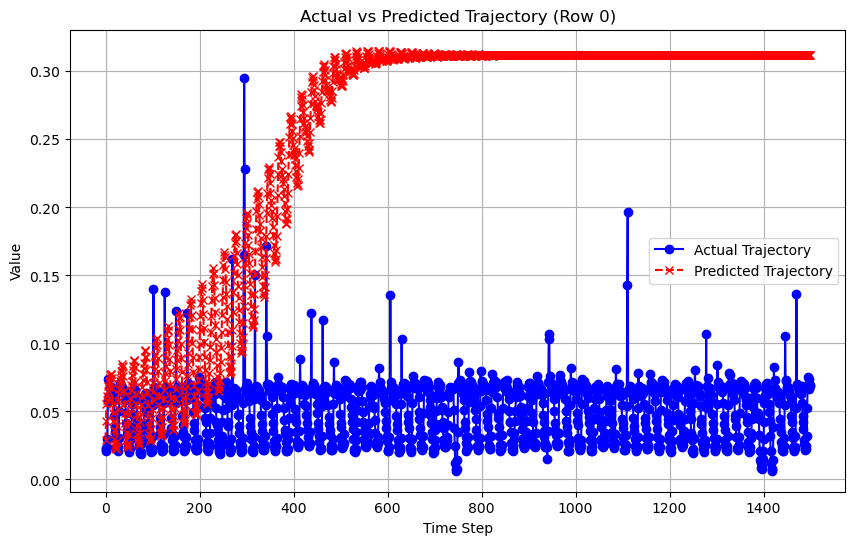

In [43]:
# Perform autoregressive predictions for one row in the validation set
# We can pick a specific row (e.g., row 0) to visualize
row_idx = 0  # You can change this to visualize predictions for different rows
initial_input = val_set[row_idx, :window_length].unsqueeze(0)

# Predict future trajectory of length 100
predicted_trajectory = autoregressive_predict(model, initial_input)

# Get the actual trajectory for comparison
actual_trajectory = val_set[row_idx].numpy()

# Plot the actual vs predicted trajectory
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_trajectory)), actual_trajectory, label="Actual Trajectory", color='blue', marker='o')
plt.plot(range(len(actual_trajectory)), predicted_trajectory.squeeze().numpy(), label="Predicted Trajectory", color='red', linestyle='--', marker='x')
plt.title(f"Actual vs Predicted Trajectory (Row {row_idx})")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# Generate predictions for all the validation dataset
initial_input = train_set[:, -window_length:]
val_predictions_tensor = autoregressive_predict(model, initial_input)

# Generate predictions for all the test dataset
initial_input = val_predictions_tensor[:, -window_length:]
test_predictions_tensor = autoregressive_predict(model, initial_input)


# Print their shapes
print(f'Validation Predictions Tensor Shape: {val_predictions_tensor.shape}')
print(f'Test Predictions Tensor Shape: {test_predictions_tensor.shape}')


Validation Predictions Tensor Shape: torch.Size([963, 1500])
Test Predictions Tensor Shape: torch.Size([963, 1500])


In [45]:
# Function to generate and save trajectory plots
def plot_and_save_trajectory(index, predicted_trajectory, actual_trajectory, save_path):
    plt.figure(figsize=(4, 4), dpi=200)
    
    # Ensure data is on CPU and convert to numpy arrays if they are PyTorch tensors
    if isinstance(predicted_trajectory, torch.Tensor):
        predicted_trajectory = predicted_trajectory.cpu().numpy()
    if isinstance(actual_trajectory, torch.Tensor):
        actual_trajectory = actual_trajectory.cpu().numpy()
    
    # Plot predicted trajectory
    plt.plot(predicted_trajectory, color='black', linewidth=3, label='Predicted Trajectory')
    
    # Set plot title, labels, etc.
    plt.title(f'Trajectory {index}')
    plt.xlabel('Time Steps')
    plt.ylabel('Trajectory Values')
    
    # Save the figure to a file
    plt.savefig(save_path)
    plt.close()

# Generate plots for the first three trajectory instances
for i in range(3):
    initial_input = val_set[i, :window_length].unsqueeze(0)  # Initial input for prediction
    predicted_trajectory = autoregressive_predict(model, initial_input)
    actual_trajectory = val_set[i].cpu().numpy()  # Actual trajectory

    # Define file name for each figure
    save_path = f"trajectory_{i}.png"
    plot_and_save_trajectory(i, predicted_trajectory.squeeze(), actual_trajectory, save_path)

In [46]:
def generate_submissions_v4(pred_val_tensor, pred_test_tensor, original_val_path, original_test_path):
    # Read the original validation and testing datasets
    original_val_df = pd.read_csv(original_val_path)
    original_test_df = pd.read_csv(original_test_path)

    # Ensure the shape of pred_val_tensor and pred_test_tensor is correct
    assert pred_val_tensor.shape[0] * pred_val_tensor.shape[1] == original_val_df.shape[0] * (original_val_df.shape[1] - 1)
    assert pred_test_tensor.shape[0] * pred_test_tensor.shape[1] == original_test_df.shape[0] * (original_test_df.shape[1] - 1)

    # Create empty lists to store ids and values
    ids = []
    values = []

    # Process validation set
    for col_idx, col in enumerate(original_val_df.columns[1:]):  # Skip the 'ids' column
        for row_idx, _ in enumerate(original_val_df[col]):
            ids.append(str(f"{col}_traffic_val_{row_idx}"))
            values.append(float(pred_val_tensor[row_idx, col_idx]))

    # Process testing set
    for col_idx, col in enumerate(original_test_df.columns[1:]):  # Skip the 'ids' column
        for row_idx, _ in enumerate(original_test_df[col]):
            ids.append(str(f"{col}_traffic_test_{row_idx}"))
            values.append(float(pred_test_tensor[row_idx, col_idx]))

    # Create the submissions dataframe
    submissions_df = pd.DataFrame({
        "ids": ids,
        "value": values
    })
    
    # Impute any null values
    submissions_df.fillna(100, inplace=True)

    # Assert the shape of the dataframe
    assert submissions_df.shape[1] == 2
    assert submissions_df.shape[0] == (original_val_df.shape[0] * (original_val_df.shape[1] - 1)) + (original_test_df.shape[0] * (original_test_df.shape[1] - 1))
    assert "ids" in submissions_df.columns
    assert "value" in submissions_df.columns

    # Save to CSV
    submissions_df.to_csv('submissions_gru.csv', index=False)

# Call the function
generate_submissions_v4(val_predictions_tensor, test_predictions_tensor, 'val.csv', 'test.csv')